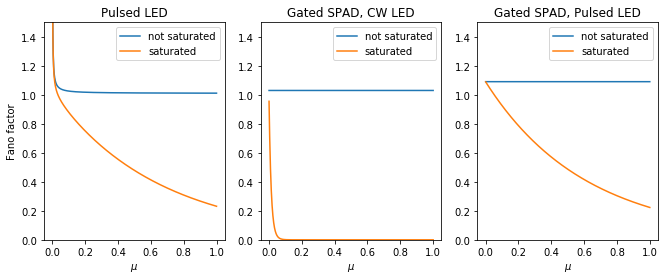

In [13]:
import numpy as np
from scipy.stats import poisson
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt

# note: dark counts are 100cps/pixel
# let mu be the mean photons incident per pixel per dead time, N_mu is the number elements in mu array
N_mu = 1024.0
mu = np.linspace(0+1/N_mu,1,int(N_mu))# offset from 0 to avoid divide by zero

T2 = 1 # camera integration time per frame for configuration 2
T3 = 0.25 # camera integration time per frame for configuration 3

def fanoFactors(mu, T, frameRate):
    # T is camera integration time per frame in nanoseconds
    # frameRate is in kHz = 1/ms = 1E-6/ns
    darkCounts = (100*T*frameRate*1E-6)/(frameRate*1E3)
    effMu = 1.01*mu+darkCounts #factor of 1.01 due to 1% probability of afterpulsing
    effMu = effMu +0.02/T*effMu # gating has precision of 20ps
    variance = effMu
    fano = variance/mu
    saturatedVariance = (1-np.exp(-effMu))-(1-np.exp(-effMu))**2
    saturFano = saturatedVariance/mu
    return fano, saturFano

(fanoShot_1, fanoSatur_1) = fanoFactors(mu, 16000, 62.5)
(fanoShot_2, fanoSatur_2) = fanoFactors((50/T2)*mu, T2, 96) # because CW illumination, dt/T = 50
(fanoShot_3, fanoSatur_3) = fanoFactors(mu, T3, 96)

fig0 = plt.figure(figsize=(11,4))
ax0 = plt.subplot(131)
ax0.plot(mu, fanoShot_1, label = 'not saturated')
ax0.plot(mu, fanoSatur_1, label = 'saturated')
ax0.legend()
ax1 = plt.subplot(132)
ax1.plot(mu, fanoShot_2, label = 'not saturated')
ax1.plot(mu, fanoSatur_2, label = 'saturated')
ax1.legend()
ax2 = plt.subplot(133)
ax2.plot(mu, fanoShot_3, label = 'not saturated')
ax2.plot(mu, fanoSatur_3, label = 'saturated')
ax2.legend()
ax0.set_ylim([0, 1.5])
ax1.set_ylim([0, 1.5])
ax2.set_ylim([0, 1.5])
ax0.set_ylabel('Fano factor')
ax0.set_xlabel('$\mu$')
ax1.set_xlabel('$\mu$')
ax2.set_xlabel('$\mu$')
ax0.set_title('Pulsed LED')
ax1.set_title('Gated SPAD, CW LED')
ax2.set_title('Gated SPAD, Pulsed LED')
plt.show()
fig0.savefig('fanoFactors.png', dpi = 1000)

(0.000225, 0.0001408333333333333, 0.0007041666666666665, 0.014999999999999999, 0.011867322079278597, 0.026536138880151092)


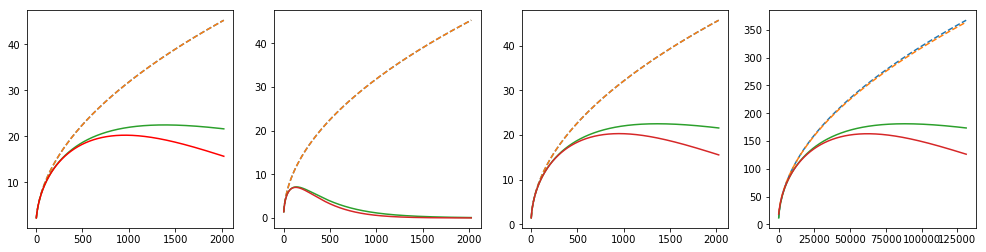

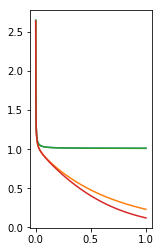

In [119]:
#measured variances for MPD SPC3 SPAD array (2024 pixels)

def noise_PIIN(T_eff, wl, deltawl):
    # T_eff is effective integration time per frame
    # wl is wavelength in nm
    # deltawl is wavelength bandwidth in nm
    cohTime = ((1E-18*wl**2)/(3E8*deltawl*1E-9))*1E9 #in ns
    M = T_eff/cohTime
    variance = 1/M
    return variance

def std_shotVsPIIN(fanoShot, fanoSat, fano_PIIN, fanoPIIN_sat, numpix,mu):
    shot = np.sqrt(fanoShot*mu*numpix)
    piin = np.sqrt(fano_PIIN*mu*numpix)
    satshot = np.sqrt(fanoSat*mu*numpix)
    satpiin = np.sqrt(fanoPIIN_sat*mu*numpix)
    return shot,piin,satshot,satpiin

PIINvar1 = noise_PIIN(1, 450, 3)
PIINvar2 = noise_PIIN(T2, 650, 2)
PIINvar3 = noise_PIIN(T3, 650, 2)

print(PIINvar1,PIINvar2,PIINvar3,np.sqrt(PIINvar1),np.sqrt(PIINvar2),np.sqrt(PIINvar3))

numpix = 2024
numpixSwissspad = 256*512

(fanoPIIN_1,fanoPIIN_1sat) = fanoFactors(mu*(1+PIINvar1*mu*numpix), 16000, 62.5)
(fanoPIIN_2,fanoPIIN_2sat) = fanoFactors((1+PIINvar1*mu*numpix)*(50/T2)*mu, T2, 96)
(fanoPIIN_3,fanoPIIN_3sat) = fanoFactors(mu*(1+PIINvar1*mu*numpix), T3, 96)
(fanoPIIN_4,fanoPIIN_4sat) = fanoFactors(mu*(1+PIINvar1*mu*numpixSwissspad), T3, 96)


(shot1,piin1,satshot1,satpiin1)=std_shotVsPIIN(fanoShot_1, fanoSatur_1, fanoPIIN_1,fanoPIIN_1sat, numpix,mu)
(shot2,piin2,satshot2,satpiin2)=std_shotVsPIIN(fanoShot_2, fanoSatur_2, fanoPIIN_2,fanoPIIN_2sat, numpix,mu)
(shot3,piin3,satshot3,satpiin3)=std_shotVsPIIN(fanoShot_3, fanoSatur_3, fanoPIIN_3,fanoPIIN_3sat, numpix,mu)
(shot4,piin4,satshot4,satpiin4)=std_shotVsPIIN(fanoShot_3, fanoSatur_3, fanoPIIN_1,fanoPIIN_1sat, numpixSwissspad,mu)

fig1 = plt.figure(figsize=(17,4))
ax01 = plt.subplot(141)
ax01.plot(mu*2024, shot1,'--', mu*2024, piin1, '--',mu*2024,satshot1,mu*2024,satpiin1,'r')
#ax01.plot(mu*2024, shot1,'--', mu*2024, piin1, '--')#,mu*2024,satshot1,mu*2024,satpiin1)
ax11 = plt.subplot(142)
ax11.plot(mu*2024, shot2,'--', mu*2024, piin2, '--',mu*2024,satshot2,mu*2024,satpiin2)
#ax11.set_ylim([0, 5])
ax21 = plt.subplot(143)
ax21.plot(mu*2024, shot3,'--', mu*2024, piin3, '--',mu*2024,satshot3,mu*2024,satpiin3)
ax31 = plt.subplot(144)
ax31.plot(mu*256*512, shot4,'--', mu*256*512, piin4, '--',mu*256*512,satshot4,mu*256*512,satpiin4)

fig2 = plt.figure(figsize=(10,4))
ax21 = plt.subplot(141)
ax21.plot(mu, fanoShot_1, mu, fanoSatur_1,mu,fanoPIIN_1,mu,fanoPIIN_1sat)
plt.show()